In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor
from scipy import optimize
from math import pi
from sklearn.datasets import make_circles
from mpl_toolkits.mplot3d import Axes3D
import random
import math
import multiprocessing

In [250]:
#csv.reader seems not to be a good way to read csv files
honing_file = open('A2-21.csv', 'r')
reader = csv.reader(honing_file)
list_honing_data = list(reader)

honing_file_2 = open('A2-22.csv', 'r')
reader_2 = csv.reader(honing_file_2)
list_honing_data_2 = list(reader_2)
iter_list_honing_data = iter(list_honing_data)
headers = []
for i in range(3):
    headers += next(iter_list_honing_data)
print(headers)

['SurfStand Software for CSV File', 'x-pixels =251', ' y-pixels =251', 'x-resolution =12(um)', ' y-resolution =12(um)', ' z-resolution =0.00535299(um)']


In [21]:
#it seems simpler to use np.loadtxt
honing_data_matrix = np.loadtxt(open('A2-21.csv', 'rb'), delimiter = ',', skiprows = 4)
honing_data_matrix_2 = np.loadtxt(open('A2-22.csv', 'rb'), delimiter = ',', skiprows = 4)
honing_data_matrix_total = np.array([honing_data_matrix, honing_data_matrix_2])
print(honing_data_matrix[1].shape)

(251,)


In [20]:
#build 251*251 arrays
x = np.zeros((251, 251))
y = np.zeros((251, 251))
#replace the zeros with 0,12,24,.....,3000
for i in range(250):
    x[i, :] = np.linspace(0, 3000, 251)
    y[i, :] = np.linspace(0, 3000, 251)
print(x[1].shape)

(251,)


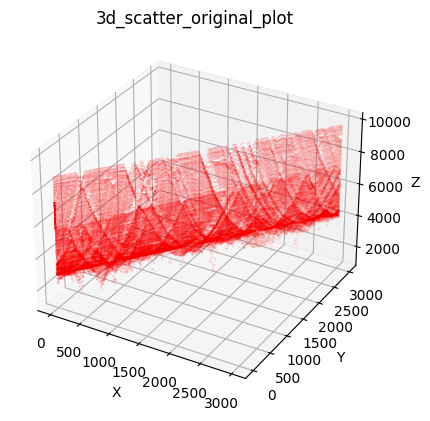

In [5]:
#the original scatter in 3D
scatter_original_plot = plt.subplot(projection = '3d')
scatter_original_plot.set_title('3d_scatter_original_plot')
scatter_original_plot.scatter(x, y, honing_data_matrix, c = 'r', s=0.01)

scatter_original_plot.set_xlabel('X')
scatter_original_plot.set_ylabel('Y')
scatter_original_plot.set_zlabel('Z')

plt.show()

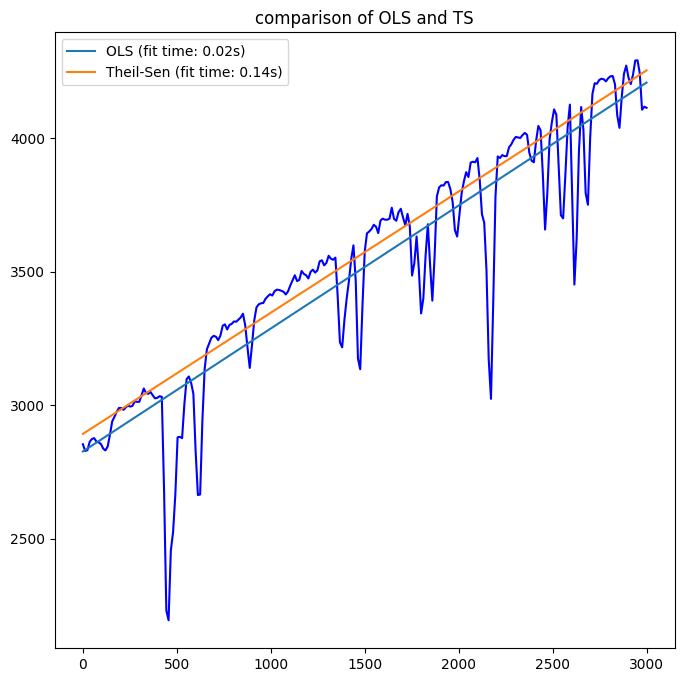

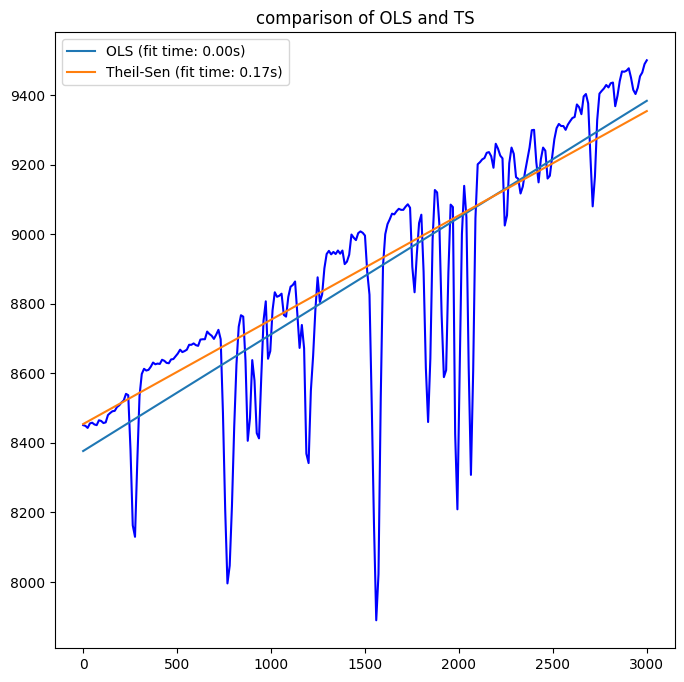

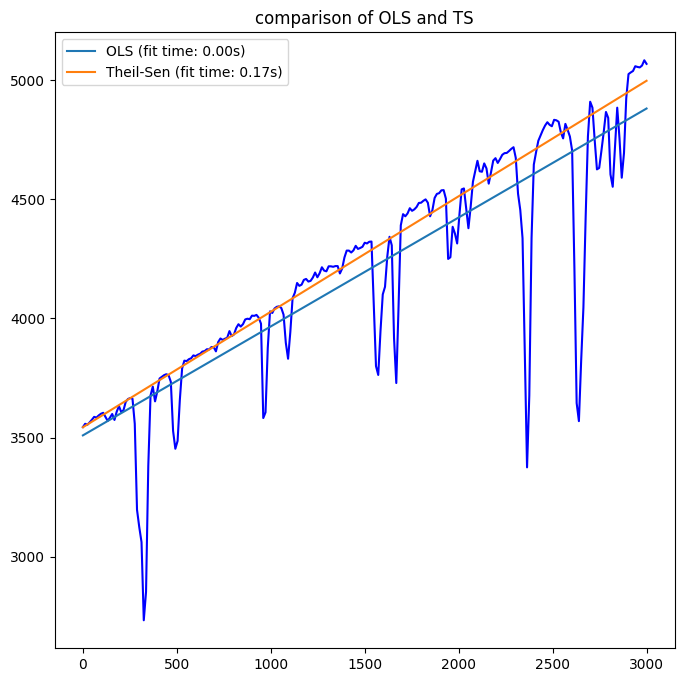

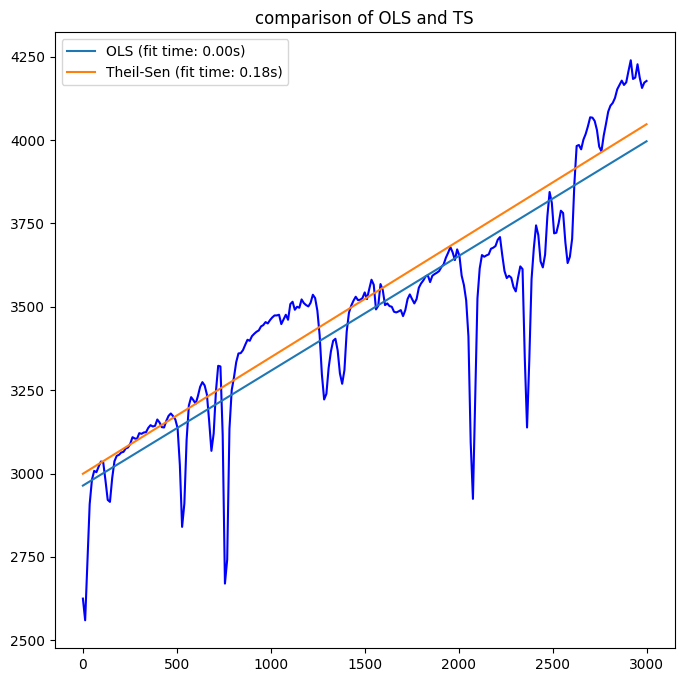

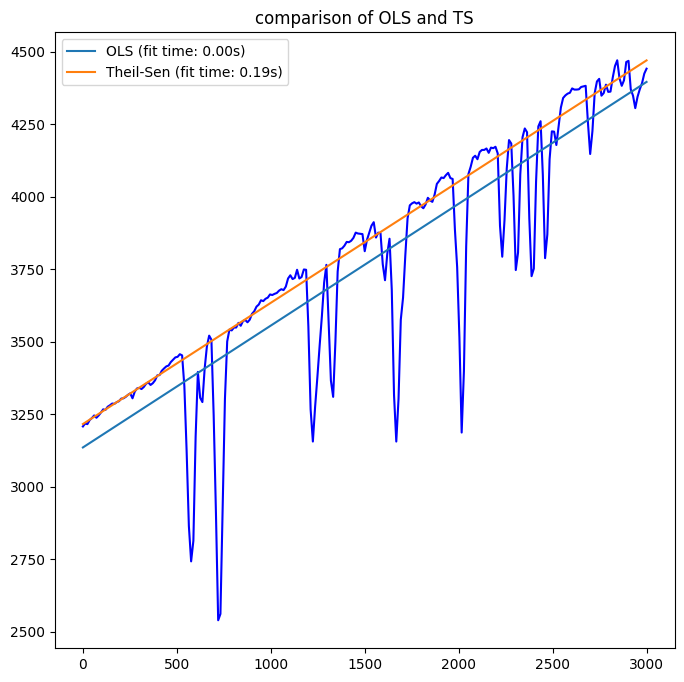

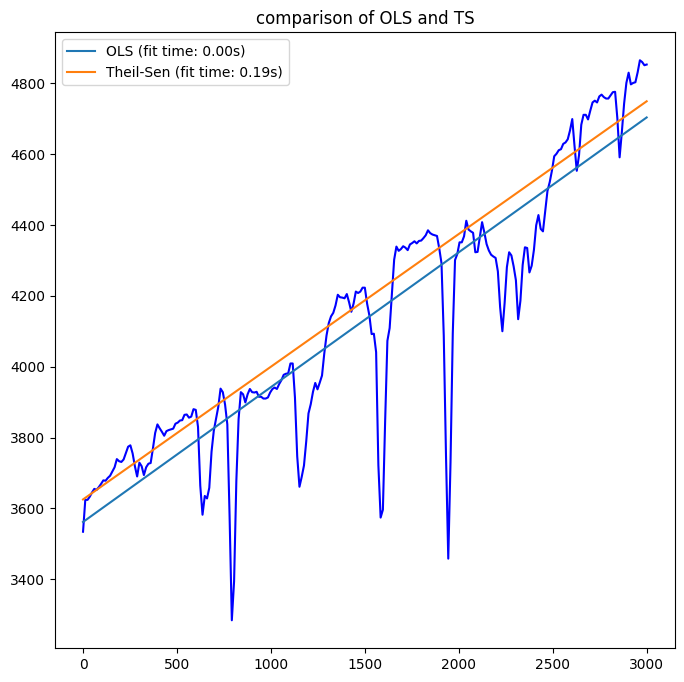

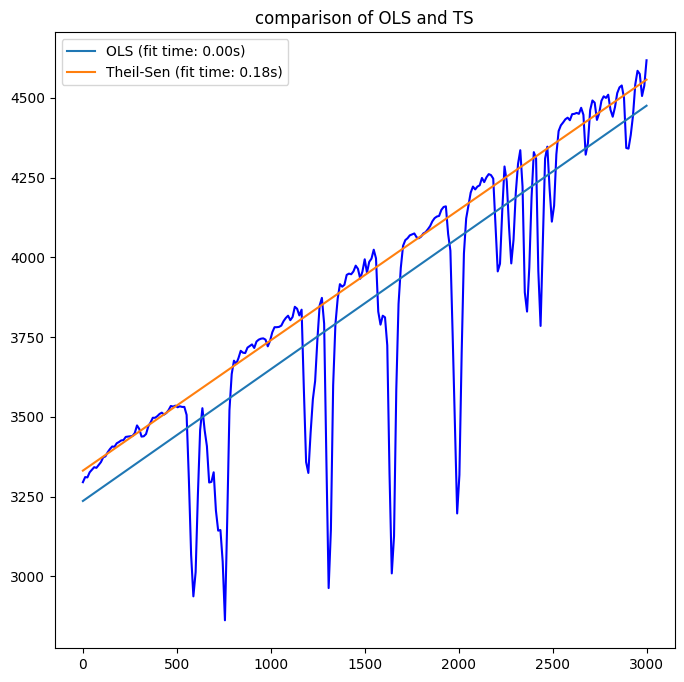

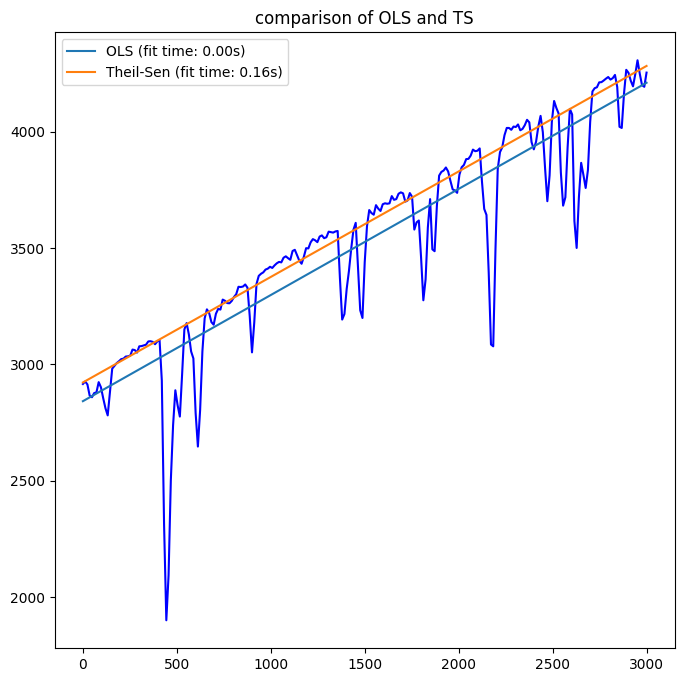

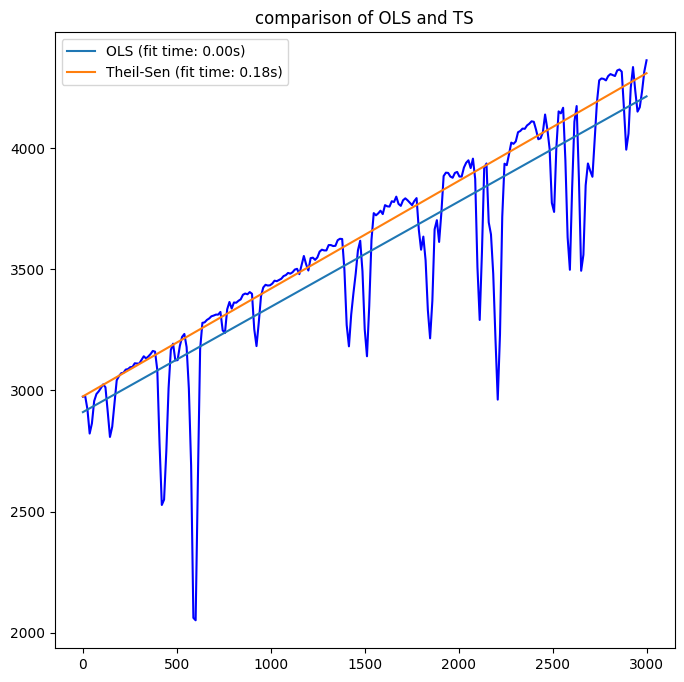

In [77]:
#set estimators
estimators = [('OLS', LinearRegression()),
              ('Theil-Sen', TheilSenRegressor())]

#draw 9 estimated plots
for i in range(9):
    #set the figure size
    plt.figure(figsize=(8, 8))
    
    #choose randomly from the input dataset
    index = np.random.randint(0, 250)
    
    #draw the plot of original data
    plt.plot(y[index], honing_data_matrix[index], c = 'b', mew=2, ms=8)
    
    #set the start and end points of the fitting line
    line_x = np.array([0, 3000])
    
    #do the fitting with OLS and Theil-Sen one by one
    for name, estimator in estimators:
        
        #record the start time
        t0 = time.time()
        
        #fitting, mind the .reshape
        estimator.fit(y[index].reshape(-1, 1), honing_data_matrix[index])
        
        #count how much time is consumed
        elapsed_time = time.time() - t0
        
        #do the predict work on the start and end points
        z_pred = estimator.predict(line_x.reshape(2, 1))
        
        #draw 
        plt.plot(line_x, z_pred, label='%s (fit time: %.2fs)' %(name, elapsed_time))
        plt.axis('tight')
        plt.title('comparison of OLS and TS')
        plt.legend(loc='upper left')
    plt.show()

Text(0.5, 1.0, 'Amplitude limiter as the filter')

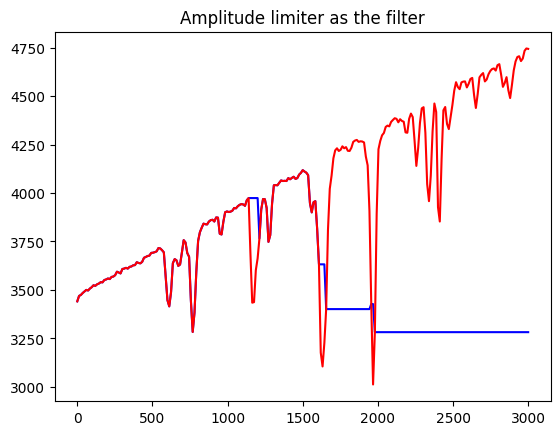

In [76]:
#try Amplitude limiter as filter to remove the deep valley data

#set the threshold of the limiter
limit = 250

#choose randomly from the input data
index = np.random.randint(0, 250)

#pick the first point of chosen data as last_data
last_data = honing_data_matrix[index, 0]

#initialize the filter data matrix
honing_data_matrix_filtered = np.zeros((251, 251))

#read through all the point within the chosen input data
for i in range(0, len(honing_data_matrix[index])):
    
    #set the current_data as the data that is under reading
    current_data = honing_data_matrix[index, i]
    
    #make comparison between the absolute value of the difference and the threshold
    if abs(current_data - last_data) <= limit:
        
        #make no change if abs less than threshold
        honing_data_matrix_filtered[index, i] = current_data
        
        #update the last_data with current_data
        last_data = current_data
    else:
        
        #replace the point with last_data if abs larger than threshold
        honing_data_matrix_filtered[index, i] = last_data
        
        #update the last_data with the point that is under reading
        last_data = honing_data_matrix_filtered[index, i]
        
#set the first filtered point aligned with the original one
honing_data_matrix_filtered[index, 0] = honing_data_matrix[index, 0]

#The results of using only the limiting filter perform poorly in some data, 
#and the gap from the true value is too large in the middle and back segments of the curve.
#The conjective reason is that the difference between adjacent two points 、
#in some deep valleys does not exceed the threshold, resulting in poor filtering effect of the filter
plt.plot(x[index], honing_data_matrix_filtered[index], c = 'b', mew=2, ms=8)
plt.plot(x[index], honing_data_matrix[index], c = 'r', mew=1, ms=4)
plt.title('Amplitude limiter as the filter')


Text(0.5, 1.0, 'Amplitude average limiter as the filter')

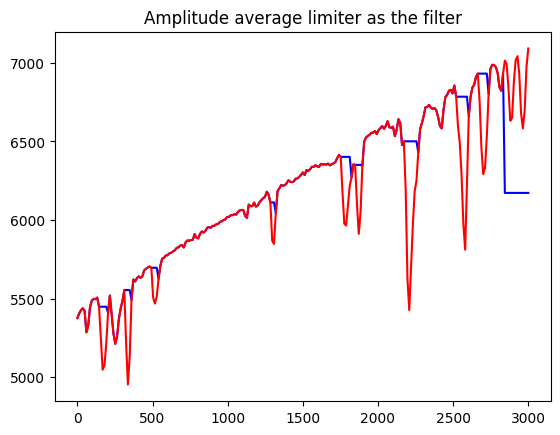

In [69]:
#try Amplitude average limiter as filter to remove the deep valley data

#set the threshold of the limiter
limit = 175

#choose randomly from the input data
index = np.random.randint(0, 250)

#pick the first point of chosen data as last_data
last_data = honing_data_matrix[index, 0]

#initialize the all_data as the temporary dataset
all_data = []

#set the sampling number 
sampling_number = 200

#initialize the filter data matrix
honing_data_matrix_filtered = np.zeros((251, 251))

#read through all the point within the chosen input data
for i in range(0, len(honing_data_matrix[index])):
    
    #set the current_data as the data that is under reading
    current_data = honing_data_matrix[index, i]
    
    #make comparison between the absolute value of the difference and the threshold
    if abs(current_data - last_data) > limit:
        
        #replace the point with last_data if abs larger than threshold
        honing_data_matrix_filtered[index, i] = last_data
        
        #update the last_data with the point that is under reading
        last_data = honing_data_matrix_filtered[index, i]
    
    #judge if the number in temporary dataset reach the sampling number
    elif len(all_data) < sampling_number - 1:
        
        #if not, add the current_data to the all_data
        all_data.append(current_data)
        
        #make no change
        honing_data_matrix_filtered[index, i] = current_data
        
        #update the last_data with current_data
        last_data = current_data
    
    else:
        #if so, calculate the mean of all_data
        all_data.insert(-1, current_data)
        mean_of_data = np.sum(all_data) / len(all_data)
        
        #replace the point with mean_data
        honing_data_matrix_filtered[index, i] = mean_of_data
        
        #update the last_data with mean_data
        last_data = mean_of_data
        
#set the first filtered point aligned with the original one
honing_data_matrix_filtered[index, 0] = honing_data_matrix[index, 0]

#draw the curve
plt.plot(x[index], honing_data_matrix_filtered[index], c = 'b', mew=2, ms=8)
plt.plot(x[index], honing_data_matrix[index], c = 'r', mew=2, ms=8)
plt.title('Amplitude average limiter as the filter')

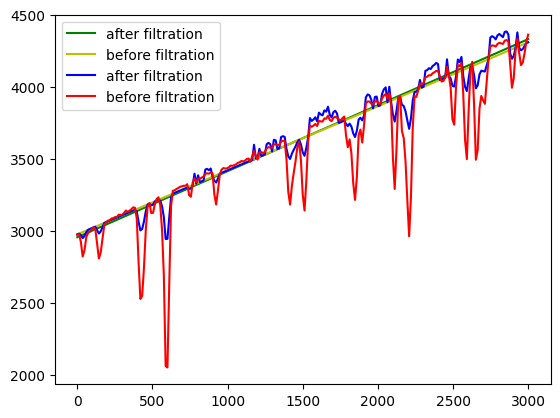

In [78]:
#Another way to think about it, TS works really well on this kind of data, so can we just use TS as a filter?

#Traverse the data points in the x (or y) direction and find the absolute value of the difference 
#between the z-value and the curve value obtained by TS 

#Set a threshold for comparison, keep the data less than the threshold, 
#and subtract the absolute value of some proportion (e.g. 3/4, 1/2) 
#as the new value for the data greater than the threshold

#Apply OLS to the newly generated data and compare the observations with OLS on the original data 

#Record the number of data obtained by monitoring and time consumed

#set the threshold of the filter
threshold = 30

#initialize the filter data matrix
honing_data_matrix_filtered = np.zeros((251, 251))

#record the predicted values after TS fitting
#here the estimator means TS estimator
honing_data_predicted = estimator.predict(y[index, :].reshape(-1, 1))

#read through all the input data
for i in range(250):
    
    #make comparison between the predicted value and the original data
    if abs(honing_data_predicted[i] - honing_data_matrix[index, i]) > threshold:
        
        #updates the value with a punishment by actual and predicted difference
        honing_data_matrix_filtered[index, i] = honing_data_matrix[index, i] + abs(honing_data_predicted[i] - honing_data_matrix[index, i]) * 3 / 4
    
    #make no change if not
    else:
        honing_data_matrix_filtered[index, i] = honing_data_predicted[i]

#set the fisrt point
honing_data_matrix_filtered[index, -1] = honing_data_predicted[-1]

#set the start point and end point
line_y = np.array([0, 3000])

#apply least square regression again onto the filtered data
OLS = LinearRegression()
OLS.fit(y[index].reshape(-1, 1), honing_data_matrix_filtered[index])
z_pred_filtered = OLS.predict(line_y.reshape(2, 1))
plt.plot(line_y, z_pred_filtered, c = 'g', label='after filtration')
plt.plot(line_y, z_pred, c= 'y', label='before filtration')
plt.plot(y[index, :], honing_data_matrix_filtered[index, :], c = 'b', mew=2, ms=8, label='after filtration')
plt.plot(y[index, :], honing_data_matrix[index, :], c = 'r', mew=2, ms=8, label='before filtration')
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

5145.509523809525
3739.0


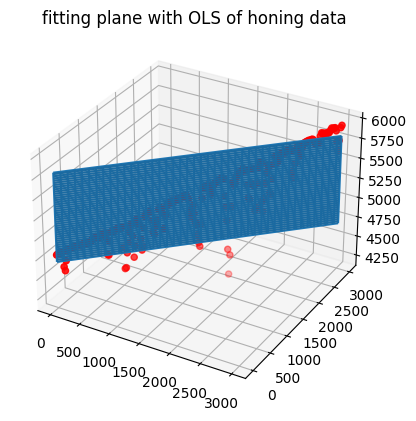

In [75]:
#try to apply OLS to 3D plane prediction

#bulid the plane with a 2D shape by using column_stack
X, Z = np.column_stack((x[index, :].flatten(),y[index, :].flatten())), honing_data_matrix[index, :].flatten()

#Least square regression 
LR = LinearRegression()

#fitting
LR.fit(X, Z)

#get the coefficent and intercept of the fitting model
a, b = LR.coef_, LR.intercept_

#set the start point and end point of prediction
m = np.array([[1200, 1200]])

#calculate the prediction value by using linear function
print(np.sum(a * m) + b)

#show the real value
print(honing_data_matrix[100, 100])

#draw the figure
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#draw the original scatter
ax.scatter(x[index, :], y[index, :], honing_data_matrix[index, :], c='r')

#draw the fitting plane
ax.plot_wireframe(x[index, :], y[index, :], LR.predict(X).reshape(-1,1))
ax.plot_surface(x[index, :], y[index, :], LR.predict(X).reshape(-1,1), alpha=0.3)
ax.set_title('fitting plane with OLS of honing data')
#ax.view_init(60, 35)

plt.show()

3440.809125549789
3739.0


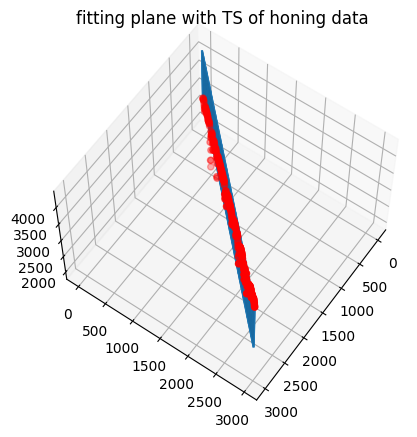

In [61]:
#try to apply TS to 3D plane prediction

#bulid the plane with a 2D shape by using column_stack
X, Z = np.column_stack((x[index, :].flatten(),y[index, :].flatten())), honing_data_matrix[index, :].flatten()

#TS regression
TS = TheilSenRegressor()

#fitting
TS.fit(X, Z)

#get the coefficent and intercept of the fitting model
a, b = TS.coef_, TS.intercept_

#set the start point and end point of prediction
m = np.array([[1200, 1200]])

#calculate the prediction value by using linear function
print(np.sum(a * m) + b)

#show the real value
print(honing_data_matrix[100, 100])

#draw the figure
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#draw the original scatter
ax.scatter(x[index, :], y[index, :], honing_data_matrix[index, :], c='r')

#draw the fitting plane
ax.plot_wireframe(x[index, :], y[index, :], TS.predict(X).reshape(-1,1))
ax.plot_surface(x[index, :], y[index, :], TS.predict(X).reshape(-1,1), alpha=0.3)
ax.set_title('fitting plane with TS of honing data')
ax.view_init(60, 35)

plt.show()

[3409.22143515]
3739.0


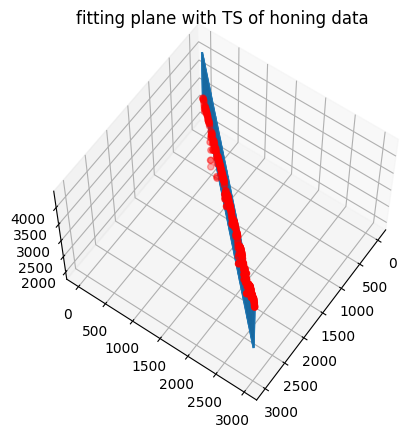

In [65]:
#try to apply RANSAC to 3D plane prediction

#bulid the plane with a 2D shape by using column_stack
X, Z = np.column_stack((x[index, :].flatten(),y[index, :].flatten())), honing_data_matrix[index, :].flatten()

#TS regression
RS = RANSACRegressor()

#fitting
RS.fit(X, Z)

#show the predict result of x:1200, y1200
m = np.array([[1200, 1200]])
print(RS.predict(m))
    
#show the real value
print(honing_data_matrix[100, 100])

#draw the figure
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#draw the original scatter
ax.scatter(x[index, :], y[index, :], honing_data_matrix[index, :], c='r')

#draw the fitting plane
ax.plot_wireframe(x[index, :], y[index, :], RS.predict(X).reshape(-1,1))
ax.plot_surface(x[index, :], y[index, :], RS.predict(X).reshape(-1,1), alpha=0.3)
ax.set_title('fitting plane with TS of honing data')
ax.view_init(60, 35)

plt.show()

In [ ]:
#TO DO LIST:
#Use box plot to help illustrate the result
#A toolbox provides assistance to help detect outliers
#Faster Robust Regression with parallel processing